# Imports

In [1]:
import sys
import os
from google.colab import drive
from google.colab import files
from dotenv import load_dotenv
import json
import warnings
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
%matplotlib inline

# Bootstrap

In [2]:
np.random.seed(31071967)

# Find and load the .env file from the current or parent directories
load_dotenv()

drive.mount('/content/drive')

with open(f"{os.getenv('PROJECT_PATH')}/src/config.json", 'r') as f:
    project_config = json.load(f)
    project_config.pop('_comment', None)
    project_config.pop('_note', None)
    f.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# sanity check
project_config["TKL"]

'AAPL'

# Download TKL data from YF

In [12]:
from datetime import date, timedelta
end_date = date.today() - timedelta(days=1)
start_date = end_date - timedelta(days=int(project_config["HISTORY_DEPTH"]))

In [13]:
tickers_yf = {
    "y"           : f"{project_config['TKL']}",
    "NASDAQ"      : "^IXIC",
    "SP500"       : "^GSPC",
    "RealEstate"  : "VNQ",
    "Oil_WTI"     : "CL=F",
    "Gold": "GC=F"
}

tickers_fred = {
 #   "Inflation_CPI" : "CPIAUCSL",
 #   "Unemployment"  : "UNRATE"
}

In [14]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr

# ---- DOWNLOAD FROM YAHOO FINANCE ----
ts_yf = yf.download(
    tickers=list(tickers_yf.values()),
    start=start_date,
    end=end_date,
    auto_adjust=True
)["Close"]

# rename columns to readable names
ts_yf.columns = list(tickers_yf.keys())

# ---- DOWNLOAD FROM FRED ----
ts_fred = pd.DataFrame()
for name, fred_code in tickers_fred.items():
    ts_fred[name] = pdr.DataReader(fred_code, "fred", start_date, end_date)


# ---- MERGE ALL ----
ts = pd.concat([ts_yf, ts_fred], axis=1)

# Fill missing daily values for macro data (monthly)
ts = ts.ffill()  # forward fill
ts = ts.dropna()  # drop any remaining rows

ts = ts.reset_index().rename(columns={"Date": "Date"})

display(ts.head(1))
display(ts.tail(1))

[*********************100%***********************]  6 of 6 completed


,Date,y,NASDAQ,SP500,RealEstate,Oil_WTI,Gold
0,2006-10-06,2.225935,59.759998,572.400024,32.947613,1349.589966,2299.98999


,Date,y,NASDAQ,SP500,RealEstate,Oil_WTI,Gold
4823,2025-12-04,280.700012,59.669998,4211.799805,89.980003,6857.120117,23505.140625


# Turn time series into supprvied learning table

In [15]:
lags = [1,5,10,22,65] # lookback days
windows =  [5,10,22,65] # statistics windows

df = ts.copy()

# Identify columns to generate features for (excluding 'Date')
feature_base_cols = [c for c in df.columns if c not in ['Date']]

for base_col in feature_base_cols: # Iterate over TKL cols

  # Generate lagged features for the current base_col
  for lag in lags:
    df[f"{base_col}_lag_{lag}"] = df[base_col].shift(lag)

  # Generate rolling window statistics for the current base_col
  for window in windows:
    df[f"{base_col}_min_{window}"] = df[base_col].rolling(window=window).min()
    df[f"{base_col}_max_{window}"] = df[base_col].rolling(window=window).max()
    df[f"{base_col}_mean_{window}"] = df[base_col].rolling(window=window).mean()
    df[f"{base_col}_std_{window}"]  = df[base_col].rolling(window=window).std()
    df[f"{base_col}_diff_{window}"] = df[base_col].diff(window)
    df[f"{base_col}_pct_{window}"] = df[base_col].pct_change(window)


df['y_next'] = df['y'].shift(-1)    # tomorrow's price
df.tail(1)['y_next'] = -1           # the target cell

df.dropna(inplace=True)

# Drop 'Date' column from X, along with 'y' and 'y_next'
X = df.drop(['Date', 'y','y_next'], axis=1)
y = df['y_next']

In [11]:
df

,Date,y,NASDAQ,SP500,RealEstate,Oil_WTI,y_lag_1,y_lag_5,y_lag_10,y_lag_22,...,Oil_WTI_std_22,Oil_WTI_diff_22,Oil_WTI_pct_22,Oil_WTI_min_65,Oil_WTI_max_65,Oil_WTI_mean_65,Oil_WTI_std_65,Oil_WTI_diff_65,Oil_WTI_pct_65,y_next
65,2007-01-10,2.909132,54.020000,35.623482,1414.849976,2459.330078,2.776271,2.513249,2.444570,2.610420,...,15.289538,31.640137,0.013033,2308.270020,2465.979980,2402.671702,45.212227,159.340088,0.069279,2.873142
66,2007-01-11,2.873142,51.880001,36.085667,1423.819946,2484.850098,2.909132,2.569034,2.444870,2.647011,...,18.910938,47.489990,0.019484,2308.270020,2484.850098,2405.334473,44.870405,173.080078,0.074869,2.837752
67,2007-01-12,2.837752,52.990002,36.200050,1430.729980,2502.820068,2.873142,2.550738,2.425376,2.661706,...,23.813145,59.959961,0.024545,2308.270020,2502.820068,2408.217398,45.023430,187.390137,0.080931,2.912130
68,2007-01-16,2.912130,51.209999,36.712555,1431.900024,2497.780029,2.837752,2.563334,2.544439,2.583428,...,26.996246,66.179932,0.027217,2330.790039,2502.820068,2411.132936,44.583919,189.510010,0.082100,2.847649
69,2007-01-17,2.847649,52.240002,36.698822,1430.619995,2479.419922,2.912130,2.776271,2.544439,2.670702,...,28.158053,47.010010,0.019327,2330.790039,2502.820068,2413.182782,44.613891,133.239990,0.056790,2.671302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4818,2025-11-26,277.549988,58.650002,91.040001,6812.609863,23214.689453,276.970001,268.559998,273.470001,268.549652,...,525.850630,-422.771484,-0.017886,21279.630859,23958.470703,22674.865084,623.867458,1670.419922,0.077534,278.850006
4819,2025-11-28,278.850006,58.549999,91.339996,6849.089844,23365.689453,277.549988,266.250000,272.950012,268.739471,...,506.128760,-461.800781,-0.019381,21279.630859,23958.470703,22702.181220,614.430487,1775.548828,0.082239,283.100006
4820,2025-12-01,283.100006,59.320000,90.290001,6812.629883,23275.919922,278.850006,271.489990,272.410004,269.438812,...,472.286698,-682.550781,-0.028489,21279.630859,23958.470703,22726.346755,605.427994,1570.759766,0.072368,286.190002
4821,2025-12-02,286.190002,58.639999,89.970001,6829.370117,23413.669922,283.100006,275.920013,267.459991,271.137146,...,465.331000,-167.470703,-0.007102,21279.630859,23958.470703,22756.471665,589.719983,1958.119141,0.091264,284.149994


In [16]:
X_train, X_test = X.iloc[:-2], X.iloc[-1:]
y_train, y_test = y.iloc[:-2], y.iloc[-1:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4756, 179), (1, 179), (4756,), (1,))

In [17]:
y

,y_next
65,2.873142
66,2.837752
67,2.912130
68,2.847649
69,2.671302
...,...
4818,278.850006
4819,283.100006
4820,286.190002
4821,284.149994


# Train, Predict, Evaluate

In [18]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

xgb = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror")

xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [19]:
pred = xgb.predict(X_test)
mae = mean_absolute_error(y_test, pred)
print("MAE:", mae)

MAE: 3.503173828125


In [20]:
last_row = X_test # Use X_test which was successfully predicted upon
tomorrow_prediction = xgb.predict(last_row)[0]
tomorrow_prediction

np.float32(277.19684)

<Figure size 1000x600 with 0 Axes>

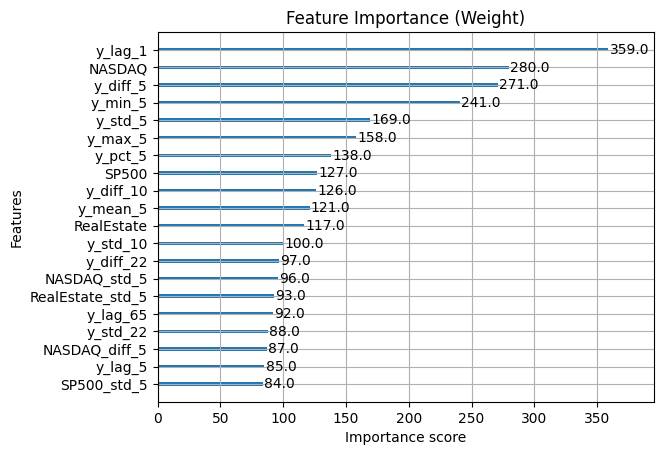

['y_lag_1', 'NASDAQ', 'y_diff_5', 'y_min_5', 'y_std_5', 'y_max_5', 'y_pct_5', 'SP500', 'y_diff_10', 'y_mean_5']


In [21]:
import matplotlib.pyplot as plt
import xgboost # Import the xgboost module

# Plot feature importance based on "weight" (number of times a feature appears in a tree)
plt.figure(figsize=(10, 6))
xgboost.plot_importance(xgb, max_num_features=20) # Pass the xgb regressor object
plt.title("Feature Importance (Weight)")
plt.show()

# Get the feature importance dictionary
# importance_type can be 'weight', 'gain', or 'cover'
importance_dict = xgb.get_booster().get_score(importance_type='weight')

# 2. Convert to a Pandas DataFrame for easy sorting and viewing
df_importance = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Score'])

# 3. Sort by Score (High to Low)
df_importance = df_importance.sort_values(by='Score', ascending=False)

# 4. Extract just the names into a Python list (for use in code)
top_weight_features_list = df_importance['Feature'].head(10).tolist()
print(top_weight_features_list)

<Figure size 1000x600 with 0 Axes>

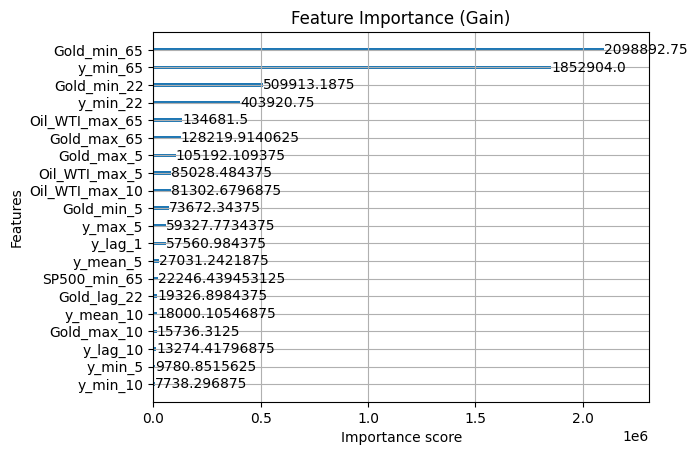

['Gold_min_65', 'y_min_65', 'Gold_min_22', 'y_min_22', 'Oil_WTI_max_65', 'Gold_max_65', 'Gold_max_5', 'Oil_WTI_max_5', 'Oil_WTI_max_10', 'Gold_min_5']


In [22]:
# OPTIONAL: Plot based on "gain" (average gain of splits which use the feature)
# "Gain" is often more accurate for finding what actually drives the prediction.
plt.figure(figsize=(10, 6))
xgboost.plot_importance(xgb, importance_type='gain', max_num_features=20) # Pass the xgb regressor object
plt.title("Feature Importance (Gain)")
plt.show()

# Get the feature importance dictionary
# importance_type can be 'weight', 'gain', or 'cover'
importance_dict = xgb.get_booster().get_score(importance_type='gain')

# 2. Convert to a Pandas DataFrame for easy sorting and viewing
df_importance = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Score'])

# 3. Sort by Score (High to Low)
df_importance = df_importance.sort_values(by='Score', ascending=False)

# 4. Extract just the names into a Python list (for use in code)
top_gain_features_list = df_importance['Feature'].head(10).tolist()
print(top_gain_features_list)

In [24]:
top_features = list(set(top_gain_features_list) | set(top_weight_features_list))
top_features

['Gold_max_65',
 'y_min_65',
 'NASDAQ',
 'y_max_5',
 'y_mean_5',
 'Gold_max_5',
 'y_std_5',
 'Oil_WTI_max_10',
 'Oil_WTI_max_65',
 'y_lag_1',
 'Oil_WTI_max_5',
 'SP500',
 'y_pct_5',
 'Gold_min_5',
 'y_min_5',
 'y_diff_10',
 'y_min_22',
 'Gold_min_22',
 'Gold_min_65',
 'y_diff_5']

In [27]:
final_df = df[['Date','y_next','y'] + top_features]
final_df

,Date,y_next,y,Gold_max_65,y_min_65,NASDAQ,y_max_5,y_mean_5,Gold_max_5,y_std_5,...,Oil_WTI_max_5,SP500,y_pct_5,Gold_min_5,y_min_5,y_diff_10,y_min_22,Gold_min_22,Gold_min_65,y_diff_5
65,2007-01-10,2.873142,2.909132,2465.979980,2.196244,54.020000,2.909132,2.673702,2459.330078,0.161403,...,1418.339966,611.599976,0.157518,2434.250000,2.550738,0.464561,2.425376,2401.179932,2308.270020,0.395882
66,2007-01-11,2.837752,2.873142,2484.850098,2.196244,51.880001,2.909132,2.734524,2484.850098,0.169211,...,1423.819946,612.400024,0.118375,2434.250000,2.550738,0.428272,2.425376,2401.179932,2308.270020,0.304108
67,2007-01-12,2.912130,2.837752,2502.820068,2.196244,52.990002,2.909132,2.791926,2502.820068,0.136869,...,1430.729980,625.500000,0.112522,2438.199951,2.563334,0.412376,2.425376,2401.179932,2308.270020,0.287014
68,2007-01-16,2.847649,2.912130,2502.820068,2.228035,51.209999,2.912130,2.861686,2502.820068,0.056559,...,1431.900024,624.599976,0.136071,2443.830078,2.776271,0.367691,2.425376,2401.179932,2330.790039,0.348796
69,2007-01-17,2.671302,2.847649,2502.820068,2.228035,52.240002,2.912130,2.875961,2502.820068,0.034198,...,1431.900024,632.099976,0.025710,2459.330078,2.837752,0.303210,2.425376,2401.179932,2330.790039,0.071378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4818,2025-11-26,278.850006,277.549988,23958.470703,226.570358,58.650002,277.549988,273.635999,23214.689453,4.764712,...,6812.609863,4165.200195,0.033475,22078.050781,266.250000,4.079987,266.250000,22078.050781,21279.630859,8.989990
4819,2025-11-28,283.100006,278.850006,23958.470703,226.570358,58.549999,278.850006,276.156000,23365.689453,2.814729,...,6849.089844,4218.299805,0.047324,22273.080078,271.489990,5.899994,266.250000,22078.050781,21279.630859,12.600006
4820,2025-12-01,286.190002,283.100006,23958.470703,226.570358,59.320000,283.100006,278.478003,23365.689453,2.791948,...,6849.089844,4239.299805,0.042764,22872.009766,275.920013,10.690002,266.250000,22078.050781,21279.630859,11.610016
4821,2025-12-02,284.149994,286.190002,23958.470703,226.570358,58.639999,286.190002,280.532001,23413.669922,3.969162,...,6849.089844,4186.600098,0.037221,23025.589844,276.970001,18.730011,266.250000,22078.050781,21279.630859,10.269989


In [28]:
df_pickle_path = f"{os.getenv('PROJECT_PATH')}{project_config['pickles_directory']}{project_config['TKL']}.df.pkl"
df_csv_path = f"{os.getenv('PROJECT_PATH')}{project_config['data_directory']}{project_config['TKL']}.df.csv"
final_df.to_pickle(df_pickle_path)
final_df.to_csv(df_csv_path)